In [1]:
import os,shutil, zipfile, warnings
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from google.colab import drive

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms 
import torchvision.datasets as datasets
from torchvision.models.resnet import resnet50

drive.mount('/content/drive')
warnings.filterwarnings("ignore")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Mounted at /content/drive


In [2]:
print("Initializing kaggle")
!rm -rf /root/.kaggle && mkdir /root/.kaggle && cp /content/drive/MyDrive/kaggle.json . && mv kaggle.json /root/.kaggle/kaggle.json

print("Downloading the dataset")
!kaggle competitions download -c dogs-vs-cats

Initializing kaggle
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 25.9MB/s]
 97% 527M/543M [00:03<00:00, 186MB/s]
100% 543M/543M [00:03<00:00, 162MB/s]
 97% 264M/271M [00:01<00:00, 159MB/s]
100% 271M/271M [00:01<00:00, 144MB/s]


In [3]:
print("Extracting the data")
with zipfile.ZipFile("train.zip") as zf:
  for member in tqdm(zf.infolist()):
    try:
      zf.extract(member, "/content")
    except zipfile.error:
      pass

Extracting the data


  0%|          | 0/25001 [00:00<?, ?it/s]

In [4]:
path, dirs, files = next(os.walk("/content/train"))
file_count = len(files)
print(file_count)

25000


In [5]:
#Create directory paths

original_dataset_dir = '/content/train'
base_dir = '/content/cats_and_dogs'
os.mkdir(base_dir) #make base directory

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [6]:
fnames = ['cat.{}.jpg'.format(i) for i in range(10000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(10000, 12500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(10000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(10000, 12500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [7]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))

print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 10000
total training dog images: 10000
total test cat images: 2500
total test dog images: 2500


In [8]:
print("Initializing the transformations for the data ")
transformations = {
    "TRAIN": transforms.Compose([     
              transforms.Resize([256,256]),
              transforms.CenterCrop((200,100)),
              transforms.RandomHorizontalFlip(p=0.9),
              transforms.RandomRotation(degrees=180),
              # transforms.Grayscale(num_output_channels=1)
              transforms.ToTensor(),
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
          ]),
      "TEST": transforms.Compose([
              transforms.Resize([256,256]),
              transforms.ToTensor(),
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
          ]),
    }

Initializing the transformations for the data 


In [9]:
BATCH = 32
print("Transforming the data")
dataset = {
    "TRAIN": datasets.ImageFolder(
        "/content/cats_and_dogs/train",
        transform = transformations["TRAIN"]
        ),
    "TEST": datasets.ImageFolder(
        "/content/cats_and_dogs/test",
        transform = transformations["TEST"]
        )
    }

print("Creating dataloaders")
dataloader = {
    "TRAIN": DataLoader(
        dataset["TRAIN"],
        batch_size = BATCH,
        shuffle = True
        ),
    "TEST": DataLoader(
        dataset["TEST"],
        batch_size = BATCH,
        shuffle = True
        )
    }

print("Data preprocessing completed.")

Transforming the data
Creating dataloaders
Data preprocessing completed.


In [10]:
def epoch(model, test_loader ,train_loader, loss_func, optim, device):

  test_loss = 0
  test_accuracy = 0
  train_loss = 0
  train_accuracy = 0

  model = model.to(device)

  print("\t\tTraining the Neural Network")
  model.train(True)
  for image, label in tqdm(train_loader):
      optim.zero_grad()      
      output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
        )
      loss.backward()
      optim.step()

      accuracy = np.average(
            np.argmax(
              output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      train_loss += loss.item()/len(train_loader) # training average loss
      train_accuracy += accuracy/len(train_loader) # training average accuracy
  model.train(False)

  print("\t\tValidating Neural Network")
  model.eval()

  for image, label in tqdm(test_loader):

      output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
      )
      
      accuracy = np.average(
        np.argmax(
            output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      test_loss += loss.item()/len(test_loader) # Validation average loss
      test_accuracy += accuracy/len(test_loader) # Validation average accuracy
      
  return (

    # TRAIN LOSS
    train_loss,

    # TRAIN ACCURACY
    train_accuracy,

    # TEST LOSS, ACCURACY
    test_loss,
    test_accuracy
  )

In [14]:
NAME = "resnet50CatsVdogs"

resnet = resnet50(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
# resnet.load_state_dict(torch.load(f"/content/drive/MyDrive/{NAME}.pth"))
resnet = resnet.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

train_loss_vals, train_accuracy_vals, test_loss_vals, test_accuracy_vals = [], [], [], []

In [15]:
EPOCH = 15 #@param {type:"integer"}

In [18]:
for ep in range(EPOCH):
  print(f"Epoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}")
  vals = epoch(resnet, dataloader["TEST"], dataloader["TRAIN"], loss_func, optimizer, device)
  train_loss_vals.append(vals[0])
  train_accuracy_vals.append(vals[1])
  test_loss_vals.append(vals[2])
  test_accuracy_vals.append(vals[3])

  print(f"Test Loss: {test_loss_vals[-1]:.3f} Test Accuracy: {test_accuracy_vals[-1]:.3f}")
  print(f"Train Loss: {train_loss_vals[-1]:.3f} Train Accuracy: {train_accuracy_vals[-1]:.3f}")
  
  if len(test_loss_vals)>2:
    if all(x > test_loss_vals[-1] for x in test_loss_vals[:-1]):
      
      model_name = os.path.join(f"/content/drive/MyDrive/",f"{NAME}.pth")
      
      print(f"Improvement detected. Saving the model\n")
      torch.save(resnet.state_dict(),model_name)

print(f"{max(train_accuracy_vals)*100:.2f}% highest train accuracy at {train_accuracy_vals.index(max(train_accuracy_vals))} epoch and {max(test_accuracy_vals)*100:.2f}% highest test accuracy at {test_accuracy_vals.index(max(test_accuracy_vals))} epoch")

Epoch: 1/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/625 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 1.107 Test Accuracy: 0.557
Train Loss: 0.557 Train Accuracy: 0.718
Epoch: 2/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/625 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.417 Test Accuracy: 0.814
Train Loss: 0.433 Train Accuracy: 0.799
Epoch: 3/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/625 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.486 Test Accuracy: 0.797
Train Loss: 0.397 Train Accuracy: 0.818
Epoch: 4/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/625 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.324 Test Accuracy: 0.861
Train Loss: 0.376 Train Accuracy: 0.830
Improvement detected. Saving the model

Epoch: 5/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/625 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.349 Test Accuracy: 0.846
Train Loss: 0.367 Train Accuracy: 0.835
Epoch: 6/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/625 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.615 Test Accuracy: 0.735
Train Loss: 0.344 Train Accuracy: 0.845
Epoch: 7/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/625 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.433 Test Accuracy: 0.804
Train Loss: 0.336 Train Accuracy: 0.850
Epoch: 8/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/625 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.340 Test Accuracy: 0.854
Train Loss: 0.327 Train Accuracy: 0.855
Epoch: 9/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/625 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.662 Test Accuracy: 0.732
Train Loss: 0.314 Train Accuracy: 0.863
Epoch: 10/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/625 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.289 Test Accuracy: 0.876
Train Loss: 0.306 Train Accuracy: 0.866
Improvement detected. Saving the model

Epoch: 11/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/625 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.400 Test Accuracy: 0.817
Train Loss: 0.298 Train Accuracy: 0.869
Epoch: 12/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/625 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.347 Test Accuracy: 0.858
Train Loss: 0.293 Train Accuracy: 0.870
Epoch: 13/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/625 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.331 Test Accuracy: 0.867
Train Loss: 0.287 Train Accuracy: 0.876
Epoch: 14/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/625 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.397 Test Accuracy: 0.858
Train Loss: 0.280 Train Accuracy: 0.881
Epoch: 15/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/625 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.259 Test Accuracy: 0.896
Train Loss: 0.278 Train Accuracy: 0.880
Improvement detected. Saving the model



NameError: ignored

In [19]:
print(f"{max(train_accuracy_vals)*100:.2f}% highest train accuracy at {train_accuracy_vals.index(max(train_accuracy_vals))} epoch and {max(test_accuracy_vals)*100:.2f}% highest test accuracy at {test_accuracy_vals.index(max(test_accuracy_vals))} epoch")

88.06% highest train accuracy at 13 epoch and 89.55% highest test accuracy at 14 epoch


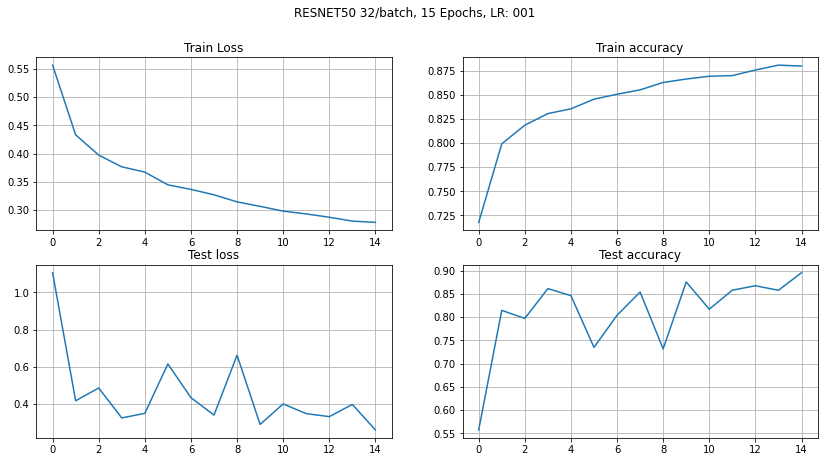

In [23]:
fig, a = plt.subplots(2,2, squeeze=False, figsize=(14,7))
a[0][0].plot(train_loss_vals)
a[0][0].set_title("Train Loss")
a[0][0].grid(True)
a[0][1].plot(train_accuracy_vals)
a[0][1].set_title("Train accuracy")
a[0][1].grid(True)
a[1][0].plot(test_loss_vals)
a[1][0].set_title("Test loss")
a[1][0].grid(True)
a[1][1].plot(test_accuracy_vals)
a[1][1].set_title("Test accuracy")
a[1][1].grid(True)
fig.suptitle(f"RESNET50 {BATCH}/batch, {EPOCH} Epochs, LR: {str(optimizer.param_groups[0]['lr']).replace('0.','')}\n")
plt.show()
performanceplot = f"/content/drive/MyDrive/{NAME}.jpg"
fig.savefig(performanceplot)